# Sentiment Analysis with **BERT** – Improved Approach
Building upon the baseline, this notebook keeps the **BERT** backbone while
introducing better data handling, stratified validation, class‑imbalance compensation,
learning‑rate scheduling, early stopping and richer evaluation metrics to boost
accuracy, precision and recall.

> **Note**: Adjust the data paths to your environment if necessary.

In [11]:

!pip install -q transformers datasets accelerate -U

!pip install -U transformers



## Importing necessary libraries

In [12]:

import os, random, numpy as np, pandas as pd, torch
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt

from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          DataCollatorWithPadding, Trainer, TrainingArguments,
                          EarlyStoppingCallback, get_linear_schedule_with_warmup, set_seed)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

SEED = 42
set_seed(SEED)


Using device: mps


## Importing the raw data 

In [13]:

DATA_DIR = Path('/Users/arkaroy/Downloads/AML-SentimentAnalysisdata')  # change if needed
train_file = DATA_DIR / 'train.csv'
test_file  = DATA_DIR / 'test.csv'

df_train = pd.read_csv(train_file, encoding='latin1')
df_test  = pd.read_csv(test_file,  encoding='latin1')

df_train = df_train.dropna(subset=['text','sentiment'])
df_test  = df_test.dropna(subset=['text','sentiment'])

label_map = {'negative':0, 'neutral':1, 'positive':2}
df_train['label'] = df_train['sentiment'].map(label_map)
df_test['label']  = df_test['sentiment'].map(label_map)

print('Class distribution:')
print(df_train['label'].value_counts())


Class distribution:
label
1    11117
2     8582
0     7781
Name: count, dtype: int64


## Splitting the data

In [14]:

train_df, val_df = train_test_split(
    df_train, test_size=0.1, random_state=SEED, stratify=df_train['label'])
print(f"Train size: {len(train_df)} | Val size: {len(val_df)}")


Train size: 24732 | Val size: 2748



## Why we need this class

It converts each sentence and its sentiment tag into the tensor bundle that BERT understands, so training just works.

## What happens inside

1. **Keep the basics**  
   - Store the sentences, their labels, the BERT tokenizer, and the maximum length we'll allow (128 tokens by default).

2. **Tell PyTorch how big it is**  
   - `__len__` reports how many samples we have.

3. **Build one sample on the fly**  
   - `__getitem__(idx)`:
     - grabs sentence `idx`,
     - runs the tokenizer (adds special tokens, trims or pads, creates an attention mask),
     - turns the label into a tensor,
     - returns a tidy dictionary with `input_ids`, `attention_mask`, and `labels`.

4. **Usage**  
   Feed this class to a `DataLoader` and you can train or evaluate the model immediately.

In [39]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = list(texts)  # Stored as self.texts
        self.labels = list(labels)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]  # Changed from self.sentences to self.texts
        label = self.labels[idx]
    
        # Tokenize the text
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
    
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

### BERT Tokenization & Dataset Preparation  

This code snippet:  

1. **Loads the BERT tokenizer**  
   - Uses `'bert-base-uncased'` (lowercase English model) via Hugging Face’s `AutoTokenizer`.  

2. **Creates PyTorch-compatible datasets**  
   - Wraps training (`train_df`), validation (`val_df`), and test (`df_test`) data into `SentimentDataset` objects.  
   - Each dataset:  
     - Takes raw text + labels,  
     - Uses the BERT tokenizer to convert text into input IDs, attention masks, etc.  

3. **Sets up dynamic padding**  
   - `DataCollatorWithPadding` ensures batches are padded to the longest sequence in the batch (efficient memory usage).  

→ **Output**: Ready-to-use datasets for training/evaluating a BERT-based sentiment model.  

In [40]:

model_name = 'bert-base-uncased'  # keep the BERT backbone
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_ds = SentimentDataset(train_df['text'], train_df['label'], tokenizer)
val_ds   = SentimentDataset(val_df['text'],   val_df['label'],   tokenizer)
test_ds  = SentimentDataset(df_test['text'],  df_test['label'],  tokenizer)

data_collator = DataCollatorWithPadding(tokenizer)


### Evaluation Metrics Computation  

This function calculates model performance metrics during validation/testing:  

1. **Input**:  
   - `eval_pred`: A tuple containing:  
     - `logits` (model's raw predictions),  
     - `true_labels` (ground truth labels).  

2. **Steps**:  
   - **Predictions**: Converts logits to class labels (`argmax`).  
   - **Accuracy**: Measures overall correctness (`accuracy_score`).  
   - **Precision/Recall/F1**: Computes weighted averages (accounts for class imbalance, with `zero_division=0` for safety).  

3. **Output**:  
   Returns a dictionary with:  
   ```python
   {
       'accuracy':  # % of correct predictions  
       'precision':  # True positives / (True + False positives)  
       'recall':   # True positives / All actual positives  
       'f1':       # Harmonic mean of precision and recall  
   }

In [41]:

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    acc = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(
        labels, preds, average='weighted', zero_division=0)
    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1}


# BERT Model Setup with Class Balancing

## What this code does:

1. **Calculates class weights** to handle imbalanced data:
   - Counts how many examples exist for each sentiment class (e.g., positive, neutral, negative)
   - Gives more weight to rare classes so the model pays more attention to them

2. **Loads a pretrained BERT model** ready for classification:
   - Uses the standard 'bert-base-uncased' model
   - Sets it up for 3-class classification (like positive/neutral/negative)

3. **Modifies the model** to use these weights:
   - Changes how the model calculates mistakes during training
   - Makes mistakes on rare classes "cost more" so the model learns them better

## Why this matters:
- Fixes the "unfairness" when some sentiment classes appear less often in your data
- Helps the model perform equally well on all sentiment types, not just the common ones

## Example output:
### Class weights: [0.2, 0.3, 0.5] # The model will care most about class 3

## When to use this:
- When your sentiment data has uneven classes (e.g., 80% positive, 15% negative, 5% neutral)
- When you want to improve performance on rare sentiment categories

In [42]:

cls_counts = train_df['label'].value_counts().sort_index()
weights = (1/cls_counts).to_numpy()
weights = weights / weights.sum()
class_weights = torch.tensor(weights, dtype=torch.float).to(device)
print('Class weights:', class_weights)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
    problem_type='single_label_classification'
).to(device)

# Override forward to plug weighted loss
#from torch.nn import CrossEntropyLoss
#orig_forward = model.forward
# def new_forward(**kwargs):
#     outputs = orig_forward(**kwargs, output_hidden_states=False)
#     logits = outputs.logits
#     labels = kwargs.get('labels')
#     if labels is not None:
#         loss_fct = CrossEntropyLoss(weight=class_weights)
#         loss = loss_fct(logits, labels)
#         outputs = (loss, logits) + outputs[2:]
#         outputs = type(outputs)(loss=loss, logits=logits)
#     return outputs
# model.forward = new_forward


Class weights: tensor([0.3836, 0.2685, 0.3478], device='mps:0')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Training Setup for BERT Sentiment Model

## What this code does:

1. **Sets up training rules** for the BERT model:
   - Trains for `4` passes through the data (epochs)
   - Uses `16` examples at a time (batch size)
   - Saves results in the `bert_results` folder

2. **Controls how learning happens**:
   - Starts with small learning steps (`2e-5` rate)
   - Gradually warms up the learning process (first 10% of training)
   - Prevents overfitting with small penalties (`weight_decay`)

3. **Smart training features**:
   - Checks performance after each epoch
   - Only keeps the 2 best model versions
   - Uses the model with best F1 score (good for imbalanced data)
   - Uses faster GPU math if available (`fp16`)

## Why these settings matter:
- The small learning rate helps BERT adjust carefully without breaking what it already knows
- The batch size balances speed and memory usage
- Saving only the best models prevents wasting disk space

## Good for:
- Training sentiment analysis models
- Situations where you want balanced performance across all sentiment classes
- When you need to train efficiently on limited hardware

In [43]:
from transformers.training_args import TrainingArguments

batch = 16
epochs = 4

args = TrainingArguments(
    output_dir='./bert_results',
    eval_strategy='epoch',  
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=batch,
    per_device_eval_batch_size=batch,
    num_train_epochs=epochs,
    weight_decay=0.01,
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    seed=SEED,
    fp16=torch.cuda.is_available(),
    logging_steps=100,
    save_total_limit=2
)

In [44]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.530300,0.519904,0.790029,0.792378,0.790029,0.790454
2,0.418200,0.514446,0.796579,0.797397,0.796579,0.796620
3,0.293200,0.644283,0.789665,0.790478,0.789665,0.789975
4,0.168100,0.822126,0.792213,0.792898,0.792213,0.792259


TrainOutput(global_step=6184, training_loss=0.3920040732059257, metrics={'train_runtime': 13317.2298, 'train_samples_per_second': 7.429, 'train_steps_per_second': 0.464, 'total_flos': 6507321047248896.0, 'train_loss': 0.3920040732059257, 'epoch': 4.0})

In [45]:

print("\nLoading best model on validation...")
trainer.model.eval()
test_output = trainer.predict(test_ds)
test_preds = test_output.predictions.argmax(axis=-1)
true_labels = df_test['label'].to_numpy()

print(classification_report(true_labels, test_preds, target_names=['negative','neutral','positive']))



Loading best model on validation...


              precision    recall  f1-score   support

    negative       0.76      0.82      0.79      1001
     neutral       0.77      0.74      0.76      1430
    positive       0.86      0.83      0.84      1103

    accuracy                           0.79      3534
   macro avg       0.79      0.80      0.80      3534
weighted avg       0.79      0.79      0.79      3534



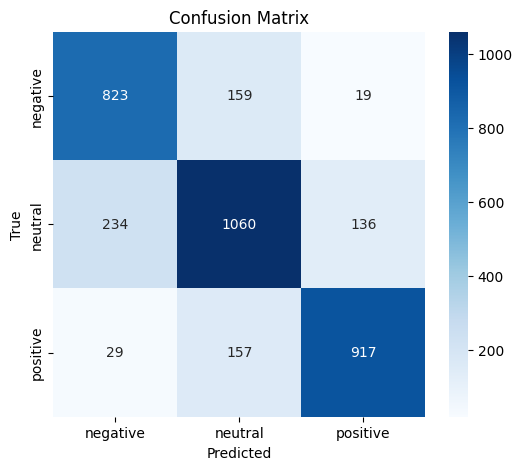

In [46]:

cm = confusion_matrix(true_labels, test_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['negative','neutral','positive'],
            yticklabels=['negative','neutral','positive'])
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix'); plt.show()
